In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

base_path = "/content/drive/MyDrive/Colab Notebooks/"

# file paths
text_features_train_path = f"{base_path}text_features_train.csv"
text_features_valid_path = f"{base_path}text_features_valid.csv"
text_features_test_path = f"{base_path}text_features_test.csv"
speech_features_train_path = f"{base_path}train_speech_features.csv"
speech_features_valid_path = f"{base_path}valid_speech_features.csv"
speech_features_test_path = f"{base_path}test_speech_features.csv"

# load feature data
text_features_train = pd.read_csv(text_features_train_path)
text_features_valid = pd.read_csv(text_features_valid_path)
text_features_test = pd.read_csv(text_features_test_path)
speech_features_train = pd.read_csv(speech_features_train_path)
speech_features_valid = pd.read_csv(speech_features_valid_path)
speech_features_test = pd.read_csv(speech_features_test_path)

In [ ]:
top_10_list = ['sd','b','sv','aa','%','ba','qy', 'x', 'ny','fc']

# include only top 10 da_tags for each
train_text_filtered = text_features_train[text_features_train['da_tag'].isin(top_10_list)]
valid_text_filtered = text_features_valid[text_features_valid['da_tag'].isin(top_10_list)]
train_speech_filtered = speech_features_train[speech_features_train['da_tag'].isin(top_10_list)]
valid_speech_filtered = speech_features_valid[speech_features_valid['da_tag'].isin(top_10_list)]

# da_tags in each dataset
print(f"\nda_tags in each dataset:\n")
for name, df in {
    "train_text_filtered": train_text_filtered,
    "valid_text_filtered": valid_text_filtered,
    "train_speech_filtered": train_speech_filtered,
    "valid_speech_filtered": valid_speech_filtered,
}.items():
    unique_tags = sorted(df["da_tag"].unique())
    print(f"{name}: {unique_tags}")



da_tags in each dataset:

train_text_filtered: ['%', 'aa', 'b', 'ba', 'fc', 'ny', 'qy', 'sd', 'sv', 'x']
valid_text_filtered: ['%', 'aa', 'b', 'ba', 'fc', 'ny', 'qy', 'sd', 'sv', 'x']
train_speech_filtered: ['%', 'aa', 'b', 'ba', 'fc', 'ny', 'qy', 'sd', 'sv', 'x']
valid_speech_filtered: ['%', 'aa', 'b', 'ba', 'fc', 'ny', 'qy', 'sd', 'sv', 'x']


### **Speech Features Classification (Model 1)**

#### Speech features clean up

In [ ]:
# exclude these columns
speech_excluded_cols = ['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time', 'split']

speech_feature_cols = [col for col in train_speech_filtered.columns
                      if col not in speech_excluded_cols]
X_speech_train = train_speech_filtered[speech_feature_cols]
X_speech_valid = valid_speech_filtered[speech_feature_cols]
y_speech_train = train_speech_filtered['da_tag']
y_speech_valid = valid_speech_filtered['da_tag']


In [ ]:
# features
print("X_speech_train columns:", X_speech_train.columns.tolist())
print("X_speech_train shape:", X_speech_train.shape)

print("\nX_speech_valid columns:", X_speech_valid.columns.tolist())
print("X_speech_valid shape:", X_speech_valid.shape)


# label
print("\ny_speech_train label:", y_speech_train.name)
print("y_speech_train shape:", y_speech_train.shape)

print("\ny_speech_valid label:", y_speech_valid.name)
print("y_speech_valid shape:", y_speech_valid.shape)

X_speech_train columns: ['Pitch_Min', 'Pitch_Max', 'Pitch_Mean', 'Pitch_SD', 'Intensity_Min', 'Intensity_Max', 'Intensity_Mean', 'Intensity_SD', 'Jitter', 'Shimmer', 'HNR', 'Speaking_Rate']
X_speech_train shape: (74111, 12)

X_speech_valid columns: ['Pitch_Min', 'Pitch_Max', 'Pitch_Mean', 'Pitch_SD', 'Intensity_Min', 'Intensity_Max', 'Intensity_Mean', 'Intensity_SD', 'Jitter', 'Shimmer', 'HNR', 'Speaking_Rate']
X_speech_valid shape: (19156, 12)

y_speech_train label: da_tag
y_speech_train shape: (74111,)

y_speech_valid label: da_tag
y_speech_valid shape: (19156,)


In [ ]:
# nans
nan_count = np.isnan(X_speech_train).sum()
print(f"number of NaN values in training data: {nan_count}")

number of NaN values in training data: Pitch_Min         5288
Pitch_Max         5288
Pitch_Mean        5288
Pitch_SD          5475
Intensity_Min        2
Intensity_Max        2
Intensity_Mean       2
Intensity_SD        23
Jitter            5438
Shimmer           5716
HNR                402
Speaking_Rate        0
dtype: int64


In [ ]:
from sklearn.impute import SimpleImputer
# simple imputer (mean) to replace nan values
imputer = SimpleImputer(strategy='mean')
X_speech_train_imputed = imputer.fit_transform(X_speech_train)
X_speech_valid_imputed = imputer.transform(X_speech_valid)

#### Speech only model (Model 1) Training

In [ ]:
# standard scaler
from sklearn.preprocessing import StandardScaler
scaler_speech = StandardScaler()
X_speech_train_scaled = scaler_speech.fit_transform(X_speech_train_imputed)
X_speech_valid_scaled = scaler_speech.transform(X_speech_valid_imputed)

In [ ]:
print(f"nans count in train data: {np.isnan(X_speech_train_scaled).sum()}")
print(f"nans count in validation data: {np.isnan(X_speech_valid_scaled).sum()}")

nans count in train data: 0
nans count in validation data: 0


In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

#preprocessing
X_train = torch.tensor(X_speech_train_scaled, dtype=torch.float32)
X_valid = torch.tensor(X_speech_valid_scaled, dtype=torch.float32)

le         = LabelEncoder().fit(y_speech_train)
y_train    = torch.tensor(le.transform(y_speech_train), dtype=torch.long)
y_valid    = torch.tensor(le.transform(y_speech_valid), dtype=torch.long)
NUM_LABELS = len(le.classes_)

In [ ]:
# 1 dim CNN + 2 layer transformer + softmax (10) classifier
from sklearn.metrics import f1_score, accuracy_score

# number of utterances
CTX = 6
#padding
PAD = -999.

class ContextDataset(Dataset):
    def __init__(self, X, y, ctx=CTX):
        self.X, self.y, self.ctx = X, y, ctx
    def __len__(self):  return len(self.X)
    def __getitem__(self, idx):
        start = max(0, idx - self.ctx + 1)
        chunk = self.X[start:idx+1]
        # left pad
        if len(chunk) < self.ctx:
            pad = torch.full((self.ctx-len(chunk), chunk.size(1)), PAD)
            chunk = torch.cat([pad, chunk], 0)
        return chunk, self.y[idx]

train_ds = ContextDataset(X_train, y_train)
valid_ds = ContextDataset(X_valid, y_valid)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=256)

In [ ]:
# 1 dim cnn + gelu + 2 layer transformer
class CNNTransformer(nn.Module):
    def __init__(self, feat_dim, num_labels, ctx=CTX, hidden=128, heads=4):
        super().__init__()
        self.mix = nn.Conv1d(feat_dim, hidden, kernel_size=1)
        # positional encoding ctx
        self.pos = nn.Parameter(torch.randn(ctx, hidden))
        enc_layer = nn.TransformerEncoderLayer(d_model=hidden,
                                               nhead=heads,
                                               dim_feedforward=hidden*4,
                                               activation='gelu',
                                               batch_first=True)
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=2)
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden),
            nn.Linear(hidden, num_labels)
        )

    def forward(self, x):
        # [batch size, hidden channels, ctx]
        x = self.mix(x.permute(0,2,1))
        x = F.gelu(x).permute(0,2,1)
        #learnable position
        x = x + self.pos
        h = self.transformer(x)
        h = h[:,-1]
        # [batch size, num_labels]
        return self.classifier(h)

model = CNNTransformer(feat_dim=X_train.shape[1], num_labels=NUM_LABELS).to('cuda')
opt   = torch.optim.AdamW(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 23.1 MB/s eta 0:00:00


In [ ]:
# optuna hyper parameter search
import optuna, torch, random, numpy as np
from copy import deepcopy

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True

# return loss, f1, acc
def run_epochs(model, opt, epochs=3):
    for _ in range(epochs):
        # train
        step(train_dl, train=True,  model=model, opt=opt)
        #valid
    _, f1, acc = step(valid_dl, train=False, model=model)
    return f1, acc

In [ ]:
# step
def step(dl, train, model, opt=None):
    tot_loss, tot_pred, tot_gold = 0, [], []
    model.train(mode=train)
    for xb, yb in dl:
        xb, yb = xb.to(device), yb.to(device)
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss   = loss_fn(logits, yb)
            if train:
                opt.zero_grad(); loss.backward(); opt.step()
        tot_loss += loss.item() * len(xb)
        tot_pred.extend(logits.argmax(1).tolist())
        tot_gold.extend(yb.tolist())
    f1  = f1_score(tot_gold, tot_pred, average='macro')
    acc = accuracy_score(tot_gold, tot_pred)
    return tot_loss/len(dl.dataset), f1, acc

#optuna objective
device   = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn  = nn.CrossEntropyLoss()

def objective(trial):
    set_seed()

    # hyper parameters
    hidden = trial.suggest_categorical('hidden', [64,128,256])
    heads  = trial.suggest_categorical('heads',  [2,4,8])
    lr     = trial.suggest_float      ('lr',     1e-5, 8e-4, log=True)

    model = CNNTransformer(X_train.shape[1], NUM_LABELS,
                           hidden=hidden, heads=heads).to(device)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr)

    #3 epochs
    f1, acc = run_epochs(model, opt, epochs=3)
    # combined metrics (0.7 * f1) + (0.3 * accuracy)
    combined = 0.7 * f1 + 0.3 * acc

    trial.set_user_attr("f1",  f1)
    trial.set_user_attr("acc", acc)
    return combined

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("\nbest parameters:", study.best_params)
print("best run scores: F1:", study.best_trial.user_attrs['f1'],
      ", accuracy:", study.best_trial.user_attrs['acc'])

[I 2025-04-22 11:34:35,146] A new study created in memory with name: no-name-67de5cf5-bb83-4849-8249-08d419acd94f


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-04-22 11:35:03,499] Trial 0 finished with value: 0.36642643052802126 and parameters: {'hidden': 128, 'heads': 4, 'lr': 0.0007899514689953601}. Best is trial 0 with value: 0.36642643052802126.
[I 2025-04-22 11:35:28,764] Trial 1 finished with value: 0.3661923267677343 and parameters: {'hidden': 128, 'heads': 8, 'lr': 0.0003351551484619512}. Best is trial 0 with value: 0.36642643052802126.
[I 2025-04-22 11:35:54,279] Trial 2 finished with value: 0.3481431282511018 and parameters: {'hidden': 256, 'heads': 8, 'lr': 0.00033234601317666616}. Best is trial 0 with value: 0.36642643052802126.
[I 2025-04-22 11:36:19,275] Trial 3 finished with value: 0.3450723974017148 and parameters: {'hidden': 128, 'heads': 8, 'lr': 3.1903239993921304e-05}. Best is trial 0 with value: 0.36642643052802126.
[I 2025-04-22 11:36:44,516] Trial 4 finished with value: 0.35546105993957644 and parameters: {'hidden': 64, 'heads': 8, 'lr': 0.00032324655565798}. Best is trial 0 with value: 0.36642643052802126.
[I 2

In [ ]:
# training with best hyperparameters
set_seed()
best   = study.best_params
model  = CNNTransformer(X_train.shape[1], NUM_LABELS,
                        hidden=best['hidden'], heads=best['heads']).to(device)
opt    = torch.optim.AdamW(model.parameters(), lr=best['lr'])

best_f1, best_acc = 0, 0
for epoch in range(25):
    step(train_dl, train=True,  model=model, opt=opt)
    _, f1, acc = step(valid_dl, train=False, model=model)

    if f1 > best_f1:
        best_f1, best_acc = f1, acc
        torch.save(deepcopy(model.state_dict()), "cnn_transformer_best.pt")

    print(f"ep {epoch:02d} | valid F1 {f1:.3f}  acc {acc:.3f} "
          f"(best F1 {best_f1:.3f})")

print("\n best trial metrics: F1:", best_f1, ", accuracy:", best_acc)


ep 00 | valid F1 0.227  acc 0.668 (best F1 0.227)
ep 01 | valid F1 0.220  acc 0.664 (best F1 0.227)
ep 02 | valid F1 0.228  acc 0.667 (best F1 0.228)
ep 03 | valid F1 0.222  acc 0.668 (best F1 0.228)
ep 04 | valid F1 0.224  acc 0.675 (best F1 0.228)
ep 05 | valid F1 0.239  acc 0.673 (best F1 0.239)
ep 06 | valid F1 0.234  acc 0.674 (best F1 0.239)
ep 07 | valid F1 0.240  acc 0.676 (best F1 0.240)
ep 08 | valid F1 0.238  acc 0.673 (best F1 0.240)
ep 09 | valid F1 0.238  acc 0.678 (best F1 0.240)
ep 10 | valid F1 0.231  acc 0.671 (best F1 0.240)
ep 11 | valid F1 0.241  acc 0.674 (best F1 0.241)
ep 12 | valid F1 0.241  acc 0.674 (best F1 0.241)
ep 13 | valid F1 0.257  acc 0.667 (best F1 0.257)
ep 14 | valid F1 0.251  acc 0.673 (best F1 0.257)
ep 15 | valid F1 0.253  acc 0.673 (best F1 0.257)
ep 16 | valid F1 0.249  acc 0.676 (best F1 0.257)
ep 17 | valid F1 0.254  acc 0.671 (best F1 0.257)
ep 18 | valid F1 0.273  acc 0.672 (best F1 0.273)
ep 19 | valid F1 0.260  acc 0.666 (best F1 0.273)


### **Text Features Classification (Model 2)**

In [36]:
# text features
text_feature_cols = [col for col in train_text_filtered.columns
                    if col not in ['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time']]
X_text_train = train_text_filtered[text_feature_cols]
X_text_valid = valid_text_filtered[text_feature_cols]
y_text_train = train_text_filtered['da_tag']
y_text_valid = valid_text_filtered['da_tag']


In [37]:
print("train_text_filtered columns:",  train_text_filtered.columns.tolist())
print("valid_text_filtered columns:",  valid_text_filtered.columns.tolist())

train_text_filtered columns: ['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time', 'function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time', 'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'word_count', 'char_count', 'has_question_mark', 'has_exclamation', 'embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7', 'embedding_8', '

In [38]:
# features
print("X_text_train columns:", X_text_train.columns.tolist())
print("X_text_train shape:", X_text_train.shape)

print("\nX_text_valid columns:", X_text_valid.columns.tolist())
print("X_text_valid shape:", X_text_valid.shape)

# labels
print("\ny_text_train column:", y_text_train.name)
print("y_text_train shape:", y_text_train.shape)

print("\ny_text_valid column:", y_text_valid.name)
print("y_text_valid shape:", y_text_valid.shape)

X_text_train columns: ['function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time', 'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'word_count', 'char_count', 'has_question_mark', 'has_exclamation', 'embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7', 'embedding_8', 'embedding_9', 'embedding_10', 'embedding_11', 'embedding_12', 'embe

In [39]:
import numpy as np, lightgbm as lgb
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy import sparse


# split into 3 groups: tfidf columns, embedding columns, LIWC columns

tfidf_cols      = [c for c in X_text_train.columns if c.startswith('tfidf_')]
embedding_cols  = [c for c in X_text_train.columns if c.startswith('embedding_')]
liwc_cols       = [c for c in X_text_train.columns
                   if c not in tfidf_cols and c not in embedding_cols]

print(f"tf-idf columns length: {len(tfidf_cols)}")
print(f"transcript sentence embeddings columns length: {len(embedding_cols)}")
print(f"liwc columns length: {len(liwc_cols)}")



tf-idf columns length: 3000
transcript sentence embeddings columns length: 768
liwc columns length: 77


In [40]:
# tfidf columns
X_A_train = X_text_train[tfidf_cols]
X_A_valid = X_text_valid[tfidf_cols]

# trainscript sentence embeddings column + liwc columns
X_B_train = X_text_train[embedding_cols + liwc_cols]
X_B_valid = X_text_valid[embedding_cols + liwc_cols]

# label encoder
le = LabelEncoder().fit(y_text_train)
y_train_enc = le.transform(y_text_train)
y_valid_enc = le.transform(y_text_valid)
n_classes   = len(le.classes_)


In [41]:
# For tfidf columns: LinearSVC
svc = LinearSVC(
        C=1.0,
        class_weight='balanced',
        max_iter=30_000,
        tol=1e-4,
        dual=False)
svc_cal = CalibratedClassifierCV(svc, cv=5, method="sigmoid")
svc_cal.fit(X_A_train, y_train_enc)

proba_A_valid = svc_cal.predict_proba(X_A_valid)

# for transcript sentence embeddings + liwc columns: LightGBM
lgbm = LGBMClassifier(
        objective="multiclass",
        num_class=n_classes,
        learning_rate=0.05,
        n_estimators=400,
        num_leaves=63,
        max_depth=-1,
        subsample=0.9,
        min_gain_to_split=1e-3,
        colsample_bytree=0.9,
        random_state=42)

lgbm.fit(X_B_train, y_train_enc)

proba_B_valid = lgbm.predict_proba(X_B_valid)

# probability stack (0.5: linearsvc, 0.5: lightgbm)
stack_proba   = 0.5 * proba_A_valid + 0.5 * proba_B_valid
stack_pred    = stack_proba.argmax(axis=1)

# evaluate
macro_f1 = f1_score(y_valid_enc, stack_pred, average="macro")
acc      = accuracy_score(y_valid_enc, stack_pred)


print(f"\nF1 (macro): {macro_f1:.4f}")
print(f"Accuracy: {acc:.4f}\n")

print(classification_report(y_valid_enc, stack_pred, target_names=le.classes_))


[LightGBM] [Warning] min_gain_to_split is set=0.001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001
[LightGBM] [Warning] min_gain_to_split is set=0.001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 202833
[LightGBM] [Info] Number of data points in the train set: 74111, number of used features: 843
[LightGBM] [Info] Start training from score -2.894333
[LightGBM] [Info] Start training from score -3.162616
[LightGBM] [Info] Start training from score -2.010507
[LightGBM] [Info] Start training from score -4.244469
[LightGBM] [Info] Start training from score -4.754981
[LightGBM] [Info] Start training from score -4.565631
[LightGBM] [Info] Start training from score -4.080023
[LightGBM] [Info] Start training from score -1.353313
[LightGBM] [Info] St

### **Combined Features Classification (Model 3)**

In [ ]:
# create combined dataset
common_train = pd.merge(
    train_text_filtered,
    train_speech_filtered[['dialog_id', 'speaker', 'start_time', 'end_time'] + speech_feature_cols],
    on=['dialog_id', 'speaker', 'start_time', 'end_time'],
    suffixes=('_text', '_speech')
)

common_valid = pd.merge(
    valid_text_filtered,
    valid_speech_filtered[['dialog_id', 'speaker', 'start_time', 'end_time'] + speech_feature_cols],
    on=['dialog_id', 'speaker', 'start_time', 'end_time'],
    suffixes=('_text', '_speech')
)


In [ ]:
# extract all feature columns for the combined model
common_excluded_cols = ['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time']
if 'split' in common_train.columns:
    common_excluded_cols.append('split')
if 'da_tag_speech' in common_train.columns:
    common_excluded_cols.append('da_tag_speech')

common_feature_cols = [col for col in common_train.columns
                      if col not in common_excluded_cols]

X_combined_train = common_train[common_feature_cols]
X_combined_valid = common_valid[common_feature_cols]
y_combined_train = common_train['da_tag']
y_combined_valid = common_valid['da_tag']


In [ ]:
# features
print("\nX_combined_train columns:", X_combined_train.columns.tolist())
print("X_combined_train shape:", X_combined_train.shape)

print("\nX_combined_valid columns:", X_combined_valid.columns.tolist())
print("X_combined_valid shape:", X_combined_valid.shape)

# labels
print("\ny_combined_train column:", y_combined_train.name)
print("y_combined_train shape:", y_combined_train.shape)

print("\ny_combined_valid column:", y_combined_valid.name)
print("y_combined_valid shape:", y_combined_valid.shape)


X_combined_train columns: ['function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time', 'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'word_count', 'char_count', 'has_question_mark', 'has_exclamation', 'embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7', 'embedding_8', 'embedding_9', 'embedding_10', 'embedding_11', 'embedding_12', 

In [ ]:
# label encoding
le = LabelEncoder().fit(y_combined_train)
y_train_enc = le.transform(y_combined_train)
y_valid_enc = le.transform(y_combined_valid)
n_classes = len(le.classes_)

# split into feature fruops
tfidf_cols = [c for c in X_combined_train.columns if c.startswith("tfidf_")]
embed_cols = [c for c in X_combined_train.columns if c.startswith("embedding_")]
liwc_cols = [c for c in X_combined_train.columns
             if c not in tfidf_cols and c not in embed_cols and c not in speech_feature_cols]


In [ ]:
# load pretrained speech model
best_speech_model = CNNTransformer(
    feat_dim=X_speech_train.shape[1],
    num_labels=NUM_LABELS,
    hidden=best['hidden'],
    heads=best['heads']
).to(device)
best_speech_model.load_state_dict(torch.load("cnn_transformer_best.pt"))
best_speech_model.eval()  # Set to evaluation mode

# cross validation
from sklearn.model_selection import StratifiedKFold
import numpy as np
import torch.nn.functional as F

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

speech_oof_train = np.zeros((len(X_combined_train), NUM_LABELS))
text_A_oof_train = np.zeros((len(X_combined_train), NUM_LABELS))
text_B_oof_train = np.zeros((len(X_combined_train), NUM_LABELS))

tfidf_cols = [c for c in X_combined_train.columns if c.startswith("tfidf_")]
embed_cols = [c for c in X_combined_train.columns if c.startswith("embedding_")]
liwc_cols = [c for c in X_combined_train.columns
             if c not in tfidf_cols and c not in embed_cols and c not in speech_feature_cols]

y_train_arr = le.transform(y_combined_train)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_combined_train, y_train_arr)):
    print(f"Processing fold {fold+1}/{n_folds}")

    X_speech_fold_train = X_combined_train.iloc[train_idx][speech_feature_cols]
    X_speech_fold_val = X_combined_train.iloc[val_idx][speech_feature_cols]
    y_fold_train = y_train_arr[train_idx]
    y_fold_val = y_train_arr[val_idx]

    X_A_fold_train = X_combined_train.iloc[train_idx][tfidf_cols]
    X_A_fold_val = X_combined_train.iloc[val_idx][tfidf_cols]

    X_B_fold_train = X_combined_train.iloc[train_idx][embed_cols + liwc_cols]
    X_B_fold_val = X_combined_train.iloc[val_idx][embed_cols + liwc_cols]

    imputer = SimpleImputer(strategy='mean')
    X_speech_fold_val_imp = imputer.fit_transform(X_speech_fold_val)

    scaler = StandardScaler()
    X_speech_fold_val_scaled = scaler.fit_transform(X_speech_fold_val_imp)

    fold_val_ds = ContextDataset(
        torch.tensor(X_speech_fold_val_scaled, dtype=torch.float32),
        torch.tensor(y_fold_val, dtype=torch.long)
    )
    fold_val_dl = DataLoader(fold_val_ds, batch_size=128, shuffle=False)

    # oof predictions speech model
    fold_preds = []
    with torch.no_grad():
        for xb, _ in fold_val_dl:
            xb = xb.to(device)
            logits = best_speech_model(xb)
            probs = F.softmax(logits, dim=1)
            fold_preds.append(probs.cpu().numpy())

    fold_preds = np.vstack(fold_preds)
    speech_oof_train[val_idx] = fold_preds

    # prediction text model
    svc = CalibratedClassifierCV(
        LinearSVC(C=1.0, class_weight='balanced', max_iter=30_000, tol=1e-4, dual=False),
        cv=3, method="sigmoid"
    )
    svc.fit(X_A_fold_train, y_fold_train)
    text_A_oof_train[val_idx] = svc.predict_proba(X_A_fold_val)

    lgbm = LGBMClassifier(
        objective="multiclass",
        num_class=NUM_LABELS,
        learning_rate=0.05,
        n_estimators=400,
        num_leaves=63,
        max_depth=-1,
        subsample=0.9,
        min_gain_to_split=1e-3,
        colsample_bytree=0.9,
        random_state=42
    )
    lgbm.fit(X_B_fold_train, y_fold_train)
    text_B_oof_train[val_idx] = lgbm.predict_proba(X_B_fold_val)


X_speech_valid = X_combined_valid[speech_feature_cols]
imputer_valid = SimpleImputer(strategy='mean')
X_speech_valid_imp = imputer_valid.fit_transform(X_speech_valid)
scaler_valid = StandardScaler()
X_speech_valid_scaled = scaler_valid.fit_transform(X_speech_valid_imp)

valid_ds = ContextDataset(
    torch.tensor(X_speech_valid_scaled, dtype=torch.float32),
    torch.tensor(le.transform(y_combined_valid), dtype=torch.long)
)
valid_dl = DataLoader(valid_ds, batch_size=128, shuffle=False)

# speech model predictions
valid_preds = []
with torch.no_grad():
    for xb, _ in valid_dl:
        xb = xb.to(device)
        logits = best_speech_model(xb)
        probs = F.softmax(logits, dim=1)
        valid_preds.append(probs.cpu().numpy())

speech_valid_preds = np.vstack(valid_preds)

#text model predictions using pre-trained models
X_A_valid = X_combined_valid[tfidf_cols]
X_B_valid = X_combined_valid[embed_cols + liwc_cols]

text_A_valid_preds = svc_cal.predict_proba(X_A_valid)
text_B_valid_preds = lgbm.predict_proba(X_B_valid)

text_oof_train = 0.5 * text_A_oof_train + 0.5 * text_B_oof_train

text_valid_preds = 0.5 * text_A_valid_preds + 0.5 * text_B_valid_preds

X_stack_train = np.hstack([speech_oof_train, text_oof_train])

# stack validation prediction
X_stack_valid = np.hstack([speech_valid_preds, text_valid_preds])

# meta model train on oof predictions
meta_model = LogisticRegression(max_iter=1000, multi_class='multinomial', C=0.1)
meta_model.fit(X_stack_train, y_train_arr)

# val set predictions
final_preds = meta_model.predict(X_stack_valid)

# evaluate
final_f1 = f1_score(le.transform(y_combined_valid), final_preds, average="macro")
final_acc = accuracy_score(le.transform(y_combined_valid), final_preds)

print(f"\nStacked Model Results:")
print(f"F1 (macro): {final_f1:.4f}")
print(f"Accuracy: {final_acc:.4f}\n")
print(classification_report(le.transform(y_combined_valid), final_preds, target_names=le.classes_))

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Stacked Model Results:
F1 (macro): 0.6702
Accuracy: 0.8559

              precision    recall  f1-score   support

           %       0.69      0.69      0.69      1033
          aa       0.57      0.35      0.43       662
           b       0.78      0.94      0.85      2409
          ba       0.87      0.70      0.78       320
          fc       0.86      0.67      0.75       121
          ny       0.50      0.01      0.03       206
          qy       0.92      0.60      0.73       342
          sd       0.81      0.89      0.85      5122
          sv       0.67      0.53      0.60      1765
           x       1.00      1.00      1.00      7170

    accuracy                           0.86     19150
   macro avg       0.77      0.64      0.67     19150
weighted avg       0.85      0.86      0.85     19150



# Confusion Matrix (Text Model)

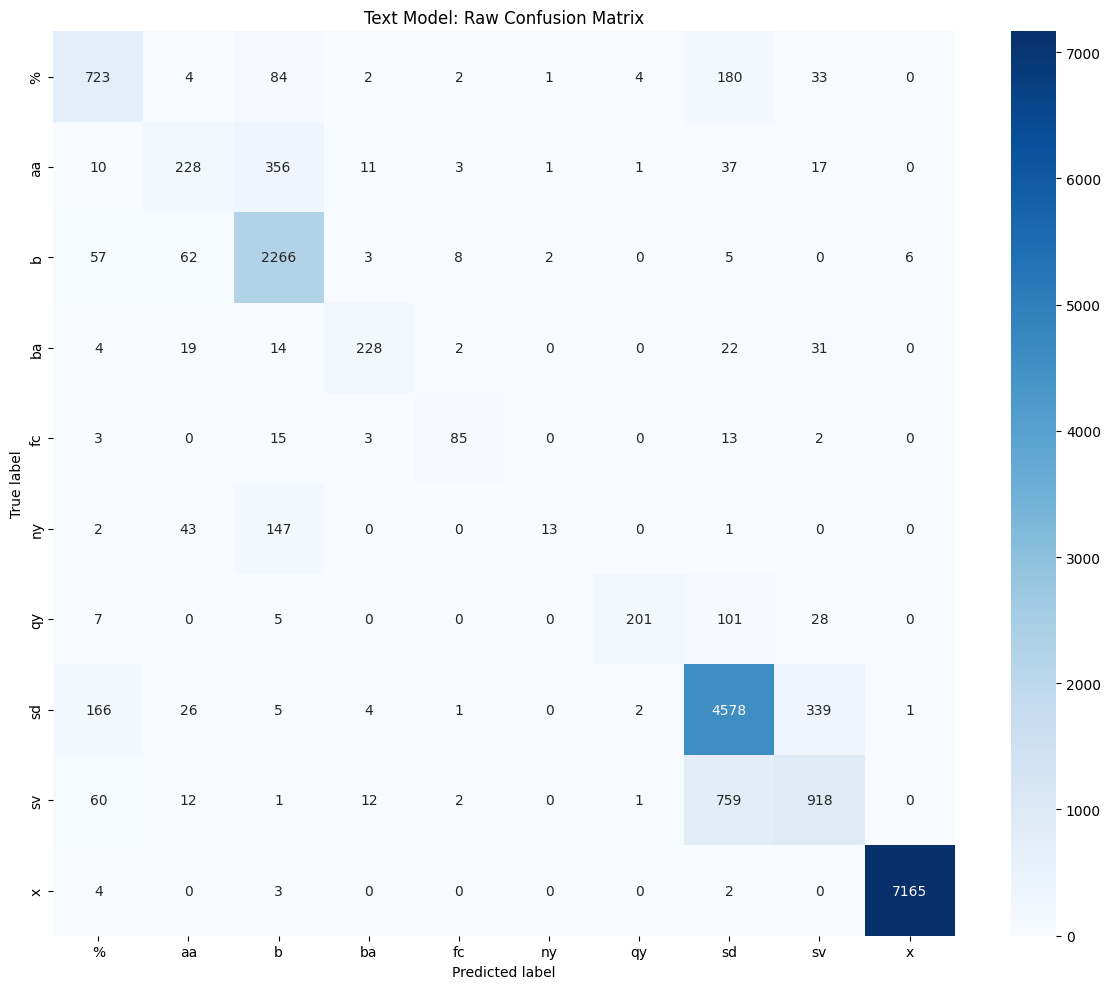

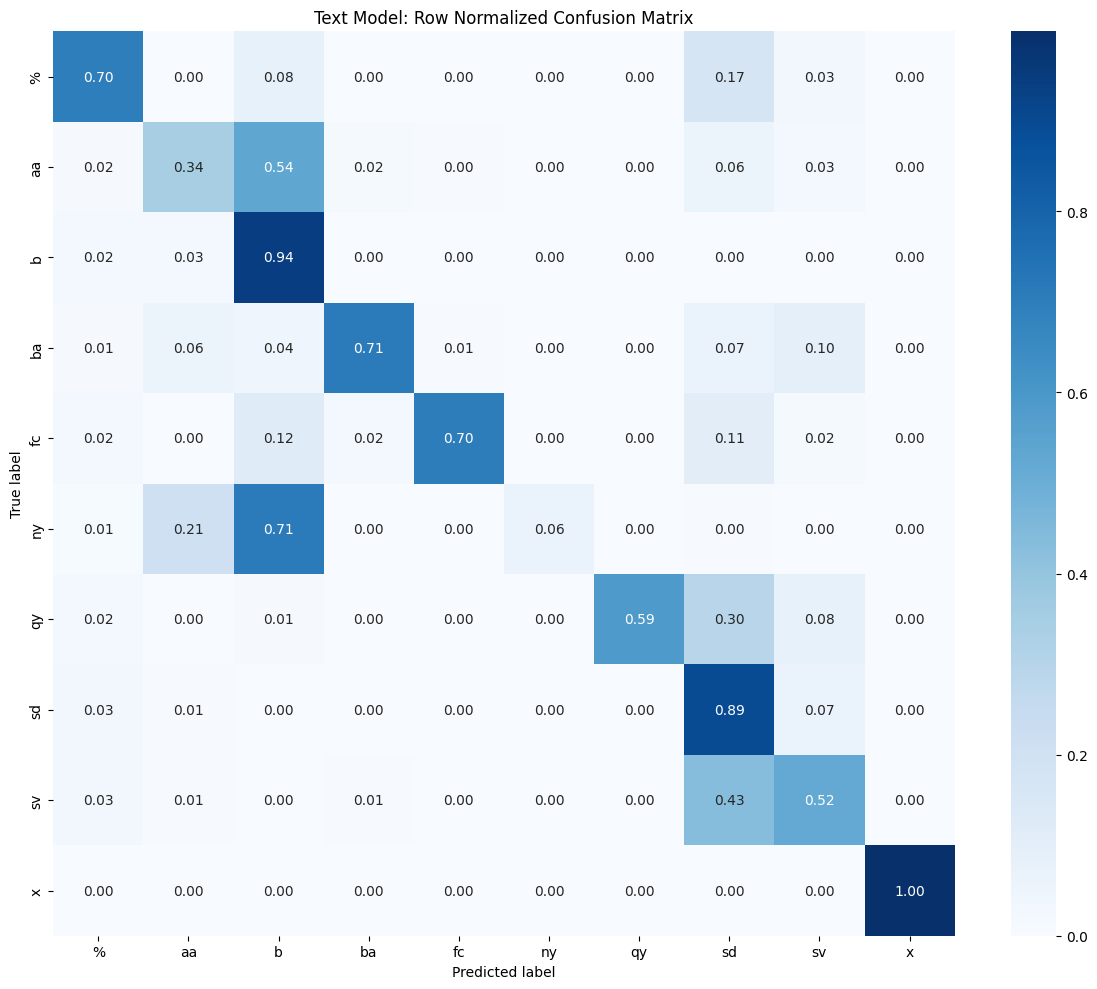

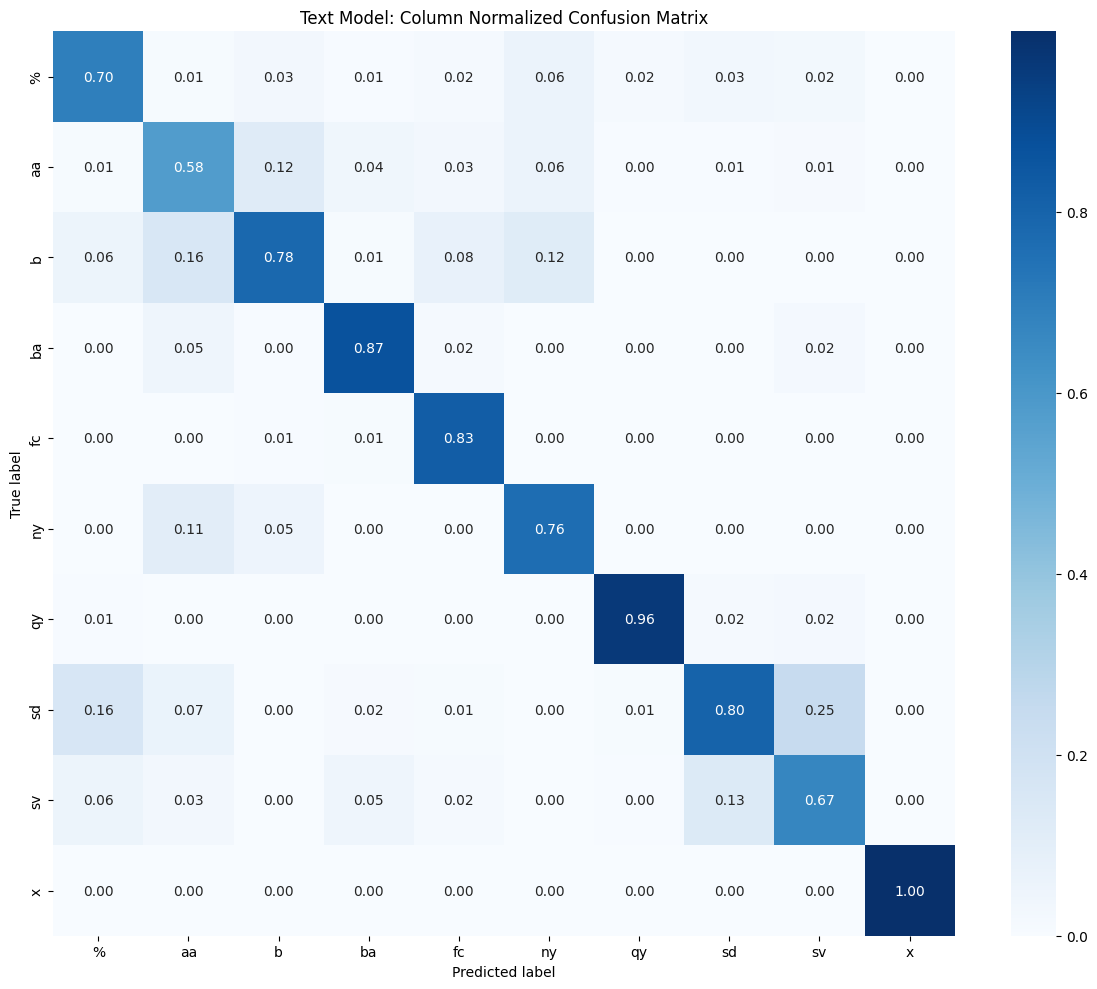


Text model classification report:
              precision    recall  f1-score   support

           %       0.70      0.70      0.70      1033
          aa       0.58      0.34      0.43       664
           b       0.78      0.94      0.85      2409
          ba       0.87      0.71      0.78       320
          fc       0.83      0.70      0.76       121
          ny       0.76      0.06      0.12       206
          qy       0.96      0.59      0.73       342
          sd       0.80      0.89      0.85      5122
          sv       0.67      0.52      0.59      1765
           x       1.00      1.00      1.00      7174

    accuracy                           0.86     19156
   macro avg       0.80      0.65      0.68     19156
weighted avg       0.85      0.86      0.85     19156


10 most confused classes text model:
True: sv, Predicted: sd - 759 instances (43.00% of true class)
True: aa, Predicted: b - 356 instances (53.61% of true class)
True: sd, Predicted: sv - 339 instances (6.

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_true = y_valid_enc
# predictions from text model
y_pred = stack_pred


conf_mat = confusion_matrix(y_true, y_pred)

# row normalize
row_norm_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# column normalization
col_norm_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=0)[np.newaxis, :]

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues, fmt='.2f'):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

# Plot the three matrices
plot_confusion_matrix(conf_mat, le.classes_, 'Text Model: Raw Confusion Matrix', fmt='d')
plot_confusion_matrix(row_norm_conf_mat, le.classes_, 'Text Model: Row Normalized Confusion Matrix')
plot_confusion_matrix(col_norm_conf_mat, le.classes_, 'Text Model: Column Normalized Confusion Matrix')

print("\nText model classification report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# confused classes
confused_pairs = []
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        if i != j:
            confused_pairs.append((le.classes_[i], le.classes_[j], conf_mat[i, j],
                                 conf_mat[i, j]/conf_mat[i, :].sum()))

confused_pairs.sort(key=lambda x: x[2], reverse=True)
top_confused = confused_pairs[:10]

print("\n10 most confused classes text model:")
for true_label, pred_label, count, percent in top_confused:
    print(f"True: {true_label}, Predicted: {pred_label} - {count} instances ({percent:.2%} of true class)")

# compare with overall model performance
print("\nText Model Metrics:")
text_model_f1 = f1_score(y_true, y_pred, average="macro")
text_model_acc = accuracy_score(y_true, y_pred)
print(f"F1 (macro): {text_model_f1:.4f}")
print(f"Accuracy: {text_model_acc:.4f}")

# Test sets

In [88]:
print("Text test columns:", text_features_test.columns.tolist())
print("Speech test columns:", speech_features_test.columns.tolist())

Text test columns: ['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time', 'function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time', 'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'word_count', 'char_count', 'has_question_mark', 'has_exclamation', 'embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7', 'embedding_8', 'embedding_

## Speech test

In [89]:
# exclude these columns
speech_excluded_cols = ['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time', 'split']

speech_feature_cols = [col for col in speech_features_test.columns
                      if col not in speech_excluded_cols]

X_speech_test = speech_features_test[speech_feature_cols]
y_speech_test = speech_features_test['da_tag']


In [99]:
# read original test.csv
original_test = pd.read_csv('test.csv')
index_cols = ['dialog_id', 'speaker', 'start_time', 'end_time']

speech_test_result = original_test.copy()

# ensure speech_features_test matches order of original_test
merged_features = pd.merge(
    original_test[index_cols],
    speech_features_test,
    on=index_cols,
    how='left'
)

# extract speech features in correct order
X_speech_test_aligned = merged_features[speech_feature_cols]

# impute missing values
imputer = SimpleImputer(strategy='mean')
X_speech_test_imputed = imputer.fit_transform(X_speech_test_aligned)

# scale
scaler = StandardScaler()
X_speech_test_scaled = scaler.fit_transform(X_speech_test_imputed)

# check if NaN values left
print(f"NaN values: {np.isnan(X_speech_test_scaled).sum()}")

# test dataset
test_ds = ContextDataset(
    torch.tensor(X_speech_test_scaled, dtype=torch.float32),
    torch.zeros(len(X_speech_test_scaled), dtype=torch.long)  # Dummy labels
)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False)

# predictions
speech_preds = []
with torch.no_grad():
    for xb, _ in test_dl:
        xb = xb.to(device)
        logits = best_speech_model(xb)
        probs = F.softmax(logits, dim=1)
        speech_preds.append(probs.cpu().numpy())

speech_preds = np.vstack(speech_preds)
speech_pred_labels = le.classes_[np.argmax(speech_preds, axis=1)]

# verify  lenghts
print(f"Length of original_test: {len(original_test)}")
print(f"Length of speech_pred_labels: {len(speech_pred_labels)}")

# add predictions to test.csv
speech_test_result['da_tag'] = speech_pred_labels

# to csv
speech_test_result.to_csv('test_sb4446_speech.csv', index=False)
print(f"speech test predictions saved to test_sb4446_speech.csv")
print(f"sample predictions: {speech_pred_labels[:5]}")

NaN values: 0
Length of original_test: 23540
Length of speech_pred_labels: 23540
speech test predictions saved to test_sb4446_speech.csv
sample predictions: ['x' '%' 'sd' 'sd' 'b']


In [100]:
print(f"first 5 rows of test_sb4446_speech.csv:\n{pd.read_csv('test_sb4446_speech.csv').head()}")

first 5 rows of test_sb4446_speech.csv:
  dialog_id speaker                  transcript da_tag  start_time  end_time  \
0    sw2019       A                         SIL      x     0.00000   2.92922   
1    sw2019       B                         SIL      %     0.00000   4.46754   
2    sw2019       A  uh do you have a pet randy     sd     2.92922   4.31867   
3    sw2019       A                         SIL     sd     4.31867   6.74838   
4    sw2019       B                     uh yeah      b     4.46754   5.01339   

   function   pronoun     ppron    i  ...      home  money  relig  death  \
0  0.000000  0.000000  0.000000  0.0  ...  0.000000    0.0    0.0    0.0   
1  0.000000  0.000000  0.000000  0.0  ...  0.000000    0.0    0.0    0.0   
2  0.571429  0.142857  0.142857  0.0  ...  0.142857    0.0    0.0    0.0   
3  0.000000  0.000000  0.000000  0.0  ...  0.000000    0.0    0.0    0.0   
4  0.000000  0.000000  0.000000  0.0  ...  0.000000    0.0    0.0    0.0   

   informal  swear  ne

# Text features

In [101]:
# text features
text_feature_cols = [col for col in text_features_test.columns
                    if col not in ['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time']]
X_text_test = text_features_test[text_feature_cols]
y_text_test = text_features_test['da_tag']

In [104]:
# features
print("X_text_test columns:", X_text_test.columns.tolist())
print("X_text_test shape:", X_text_test.shape)

# labels
print("\ny_text_test column:", y_text_test.name)
print("y_text_test shape:", y_text_test.shape)


X_text_test columns: ['function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time', 'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler', 'word_count', 'char_count', 'has_question_mark', 'has_exclamation', 'embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7', 'embedding_8', 'embedding_9', 'embedding_10', 'embedding_11', 'embedding_12', 'embed

In [105]:
original_test = pd.read_csv('test.csv')
index_cols = ['dialog_id', 'speaker', 'start_time', 'end_time']

text_test_result = original_test.copy()

merged_features = pd.merge(
    original_test[index_cols],
    text_features_test,
    on=index_cols,
    how='left'
)

tfidf_cols = [c for c in merged_features.columns if c.startswith("tfidf_")]
embed_cols = [c for c in merged_features.columns if c.startswith("embedding_")]
liwc_cols = [c for c in merged_features.columns
             if c not in tfidf_cols and c not in embed_cols and c not in index_cols and c != 'da_tag']

X_A_test = merged_features[tfidf_cols]  # TF-IDF features
X_B_test = merged_features[embed_cols + liwc_cols]  # Embedding + LIWC features

print(f"X_A_test shape (TF-IDF): {X_A_test.shape}")
print(f"X_B_test shape (Embeddings + LIWC): {X_B_test.shape}")

#svc
text_A_test_preds = svc_cal.predict_proba(X_A_test)
#lgbm
text_B_test_preds = lgbm.predict_proba(X_B_test)

# combine predictions (0.5 each)
text_test_preds = 0.5 * text_A_test_preds + 0.5 * text_B_test_preds
text_pred_labels = le.classes_[np.argmax(text_test_preds, axis=1)]

# verify lengths
print(f"Length of original_test: {len(original_test)}")
print(f"Length of text_pred_labels: {len(text_pred_labels)}")

# add predictions to test.csv
text_test_result['da_tag'] = text_pred_labels

# save to csv
text_test_result.to_csv('test_sb4446_text.csv', index=False)
print(f"Text test predictions saved to test_sb4446_text.csv")
print(f"Sample predictions: {text_pred_labels[:5]}")

X_A_test shape (TF-IDF): (23540, 3000)
X_B_test shape (Embeddings + LIWC): (23540, 845)
[LightGBM] [Warning] min_gain_to_split is set=0.001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001
Length of original_test: 23540
Length of text_pred_labels: 23540
Text test predictions saved to test_sb4446_text.csv
Sample predictions: ['x' 'x' 'qy' 'x' 'ny']


In [106]:
print(f"first 5 rows of test_sb4446_text.csv:\n{pd.read_csv('test_sb4446_text.csv').head()}")

first 5 rows of test_sb4446_text.csv:
  dialog_id speaker                  transcript da_tag  start_time  end_time  \
0    sw2019       A                         SIL      x     0.00000   2.92922   
1    sw2019       B                         SIL      x     0.00000   4.46754   
2    sw2019       A  uh do you have a pet randy     qy     2.92922   4.31867   
3    sw2019       A                         SIL      x     4.31867   6.74838   
4    sw2019       B                     uh yeah     ny     4.46754   5.01339   

   function   pronoun     ppron    i  ...      home  money  relig  death  \
0  0.000000  0.000000  0.000000  0.0  ...  0.000000    0.0    0.0    0.0   
1  0.000000  0.000000  0.000000  0.0  ...  0.000000    0.0    0.0    0.0   
2  0.571429  0.142857  0.142857  0.0  ...  0.142857    0.0    0.0    0.0   
3  0.000000  0.000000  0.000000  0.0  ...  0.000000    0.0    0.0    0.0   
4  0.000000  0.000000  0.000000  0.0  ...  0.000000    0.0    0.0    0.0   

   informal  swear  nets

# combined features

In [107]:
original_test = pd.read_csv('test.csv')
index_cols = ['dialog_id', 'speaker', 'start_time', 'end_time']

multi_test_result = original_test.copy()

print("Creating aligned combined test dataset...")
merged_speech = pd.merge(
    original_test[index_cols],
    speech_features_test[['dialog_id', 'speaker', 'start_time', 'end_time'] + speech_feature_cols],
    on=index_cols,
    how='left'
)

merged_text = pd.merge(
    original_test[index_cols],
    text_features_test,
    on=index_cols,
    how='left'
)

print(f"original test shape: {original_test.shape}")
print(f"merged speech features shape: {merged_speech.shape}")
print(f"merged text features shape: {merged_text.shape}")

# speech features
X_speech_test_multi = merged_speech[speech_feature_cols]

# process speech features
print("Processing speech features for multimodal model...")
imputer_multi = SimpleImputer(strategy='mean')
X_speech_test_multi_imputed = imputer_multi.fit_transform(X_speech_test_multi)
scaler_multi = StandardScaler()
X_speech_test_multi_scaled = scaler_multi.fit_transform(X_speech_test_multi_imputed)

print(f"NaN values in processed multi speech data: {np.isnan(X_speech_test_multi_scaled).sum()}")

test_ds_multi = ContextDataset(
    torch.tensor(X_speech_test_multi_scaled, dtype=torch.float32),
    torch.zeros(len(X_speech_test_multi_scaled), dtype=torch.long)
)
test_dl_multi = DataLoader(test_ds_multi, batch_size=128, shuffle=False)

# speech model predictions
print("speech model predictions..")
speech_preds_multi = []
with torch.no_grad():
    for xb, _ in test_dl_multi:
        xb = xb.to(device)
        logits = best_speech_model(xb)
        probs = F.softmax(logits, dim=1)
        speech_preds_multi.append(probs.cpu().numpy())

speech_preds_multi = np.vstack(speech_preds_multi)

tfidf_cols = [c for c in merged_text.columns if c.startswith("tfidf_")]
embed_cols = [c for c in merged_text.columns if c.startswith("embedding_")]
liwc_cols = [c for c in merged_text.columns
             if c not in tfidf_cols and c not in embed_cols and c not in index_cols and c != 'da_tag']

#text features
X_A_test_multi = merged_text[tfidf_cols]
X_B_test_multi = merged_text[embed_cols + liwc_cols]

print(f"X_A_test_multi shape (tfidf): {X_A_test_multi.shape}")
print(f"X_B_test_multi shape (sentence mbeddings + LIWC): {X_B_test_multi.shape}")

# text model predictions
print("text model predictions...")
text_A_preds_multi = svc_cal.predict_proba(X_A_test_multi)
text_B_preds_multi = lgbm.predict_proba(X_B_test_multi)
text_preds_multi = 0.5 * text_A_preds_multi + 0.5 * text_B_preds_multi

#stack predictions
X_stack_test = np.hstack([speech_preds_multi, text_preds_multi])

# final predictions meta model
multi_pred_labels = le.classes_[meta_model.predict(X_stack_test)]

# verify lenghts
print(f"length of original_test: {len(original_test)}")
print(f"length of multi_pred_labels: {len(multi_pred_labels)}")

multi_test_result['da_tag'] = multi_pred_labels

multi_test_result.to_csv('test_sb4446_multi.csv', index=False)
print(f"Multi-modal test predictions saved to test_sb4446_multi.csv")
print(f"Sample predictions: {multi_pred_labels[:5]}")

Creating aligned combined test dataset...
original test shape: (23540, 79)
merged speech features shape: (23540, 16)
merged text features shape: (23540, 3850)
Processing speech features for multimodal model...
NaN values in processed multi speech data: 0
speech model predictions..
X_A_test_multi shape (tfidf): (23540, 3000)
X_B_test_multi shape (sentence mbeddings + LIWC): (23540, 845)
text model predictions...
[LightGBM] [Warning] min_gain_to_split is set=0.001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001
length of original_test: 23540
length of multi_pred_labels: 23540
Multi-modal test predictions saved to test_sb4446_multi.csv
Sample predictions: ['x' 'x' 'qy' 'x' 'b']


In [108]:
print(f"first 5 rows of test_sb4446_multi.csv:\n{pd.read_csv('test_sb4446_multi.csv').head()}")

first 5 rows of test_sb4446_multi.csv:
  dialog_id speaker                  transcript da_tag  start_time  end_time  \
0    sw2019       A                         SIL      x     0.00000   2.92922   
1    sw2019       B                         SIL      x     0.00000   4.46754   
2    sw2019       A  uh do you have a pet randy     qy     2.92922   4.31867   
3    sw2019       A                         SIL      x     4.31867   6.74838   
4    sw2019       B                     uh yeah      b     4.46754   5.01339   

   function   pronoun     ppron    i  ...      home  money  relig  death  \
0  0.000000  0.000000  0.000000  0.0  ...  0.000000    0.0    0.0    0.0   
1  0.000000  0.000000  0.000000  0.0  ...  0.000000    0.0    0.0    0.0   
2  0.571429  0.142857  0.142857  0.0  ...  0.142857    0.0    0.0    0.0   
3  0.000000  0.000000  0.000000  0.0  ...  0.000000    0.0    0.0    0.0   
4  0.000000  0.000000  0.000000  0.0  ...  0.000000    0.0    0.0    0.0   

   informal  swear  net